In [1]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening under the hood, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)

# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
assert tokenized_text == ['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [2]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Set the model in evaluation mode to deactivate the DropOut modules
# This is IMPORTANT to have reproducible results during evaluation!
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cuda')
segments_tensors = segments_tensors.to('cuda')
model.to('cuda')

# Predict hidden states features for each layer
with torch.no_grad():
    # See the models docstrings for the detail of the inputs
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    # Transformers models always output tuples.
    # See the models docstrings for the detail of all the outputs
    # In our case, the first element is the hidden state of the last layer of the Bert model
    encoded_layers = outputs[0]
# We have encoded our input sequence in a FloatTensor of shape (batch size, sequence length, model hidden dimension)
assert tuple(encoded_layers.shape) == (1, len(indexed_tokens), model.config.hidden_size)

In [3]:
from pathlib import Path
from transformers.convert_graph_to_onnx import convert

# Handles all the above steps for you
convert(framework="pt", model="bert-base-cased", output=Path("onnx/bert-base-cased.onnx"), opset=11)

ONNX opset version set to: 11
Loading pipeline (model: bert-base-cased, tokenizer: bert-base-cased)


Exception: Folder onnx is not empty, aborting conversion

In [5]:
from onnxruntime import GraphOptimizationLevel, InferenceSession, SessionOptions, get_all_providers
from contextlib import contextmanager
from dataclasses import dataclass
from time import time
from tqdm import trange

def create_model_for_provider(model_path: str, provider: str) -> InferenceSession: 
  
  assert provider in get_all_providers(), f"provider {provider} not found, {get_all_providers()}"

  # Few properties that might have an impact on performances (provided by MS)
  options = SessionOptions()
  options.intra_op_num_threads = 1
  options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

  # Load the model as a graph and prepare the CPU backend 
  session = InferenceSession(model_path, options, providers=[provider])
  session.disable_fallback()
    
  return session

@contextmanager
def track_infer_time(buffer: [int]):
    start = time()
    yield
    end = time()

    buffer.append(end - start)


@dataclass
class OnnxInferenceResult:
  model_inference_time: [int]  
  optimized_model_path: str

In [6]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
cpu_model = create_model_for_provider("onnx/bert-base-cased.onnx", "CPUExecutionProvider")

# Inputs are provided through numpy array
model_inputs = tokenizer("My name is Bert", return_tensors="pt")
inputs_onnx = {k: v.cpu().detach().numpy() for k, v in model_inputs.items()}

# Run the model (None = get all the outputs)
sequence, pooled = cpu_model.run(None, inputs_onnx)

# Print information about outputs

print(f"Sequence output: {sequence.shape}, Pooled output: {pooled.shape}")

Sequence output: (1, 6, 768), Pooled output: (1, 768)


In [12]:
from transformers import BertModel
from tqdm import trange

PROVIDERS = {
#    ("cpu", "PyTorch CPU"),
#  Uncomment this line to enable GPU benchmarking
    ("cuda:0", "PyTorch GPU")
}

results = {}

for device, label in PROVIDERS:
    
    # Move inputs to the correct device
    model_inputs_on_device = {
        arg_name: tensor.to(device)
        for arg_name, tensor in model_inputs.items()
    }

    # Add PyTorch to the providers
    model_pt = BertModel.from_pretrained("bert-base-cased").to(device)
    for _ in trange(10, desc="Warming up"):
      model_pt(**model_inputs_on_device)

    # Compute 
    time_buffer = []
    for _ in trange(100, desc=f"Tracking inference time on PyTorch"):
      with track_infer_time(time_buffer):
        model_pt(**model_inputs_on_device)

    # Store the result
    results[label] = OnnxInferenceResult(
        time_buffer, 
        None
    )

Tracking inference time on PyTorch: 100%|██████████| 100/100 [00:00<00:00, 109.90it/s]


In [13]:
PROVIDERS = {
#    ("CPUExecutionProvider", "ONNX CPU"),
#  Uncomment this line to enable GPU benchmarking
     ("CUDAExecutionProvider", "ONNX GPU")
}


for provider, label in PROVIDERS:
    # Create the model with the specified provider
    model = create_model_for_provider("onnx/bert-base-cased.onnx", provider)

    # Keep track of the inference time
    time_buffer = []

    # Warm up the model
    model.run(None, inputs_onnx)

    # Compute 
    for _ in trange(100, desc=f"Tracking inference time on {provider}"):
      with track_infer_time(time_buffer):
          model.run(None, inputs_onnx)

    # Store the result
    results[label] = OnnxInferenceResult(
      time_buffer,
      model.get_session_options().optimized_model_filepath
    )

Tracking inference time on CUDAExecutionProvider: 100%|██████████| 100/100 [00:00<00:00, 555.09it/s]


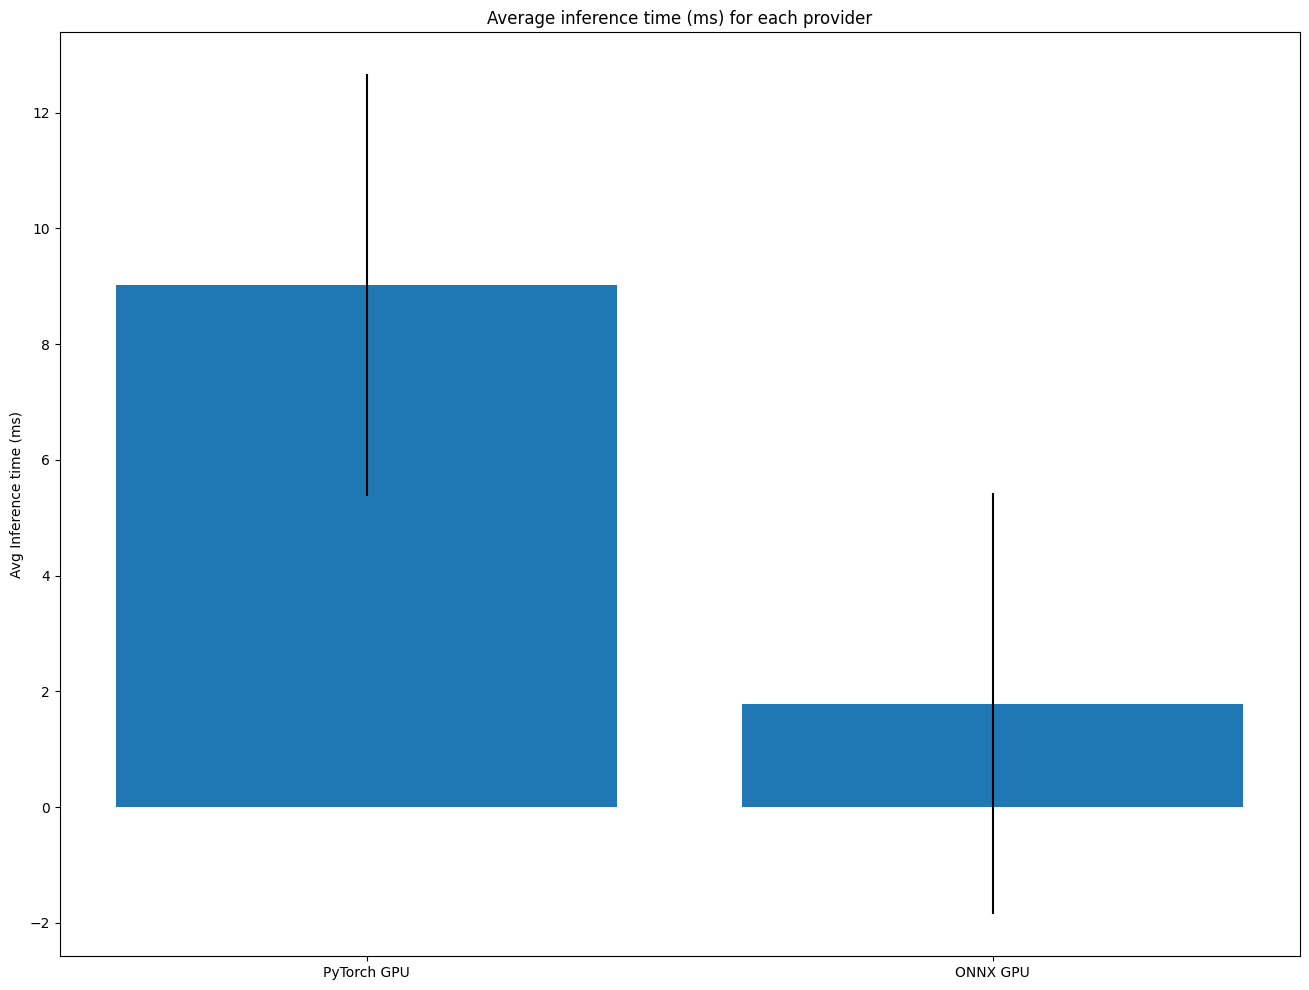

In [14]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os


# Compute average inference time + std
time_results = {k: np.mean(v.model_inference_time) * 1e3 for k, v in results.items()}
time_results_std = np.std([v.model_inference_time for v in results.values()]) * 1000

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_ylabel("Avg Inference time (ms)")
ax.set_title("Average inference time (ms) for each provider")
ax.bar(time_results.keys(), time_results.values(), yerr=time_results_std)
plt.show()

In [15]:
print(time_results)

{'PyTorch GPU': 9.023196697235107, 'ONNX GPU': 1.7875337600708008}
